In [134]:
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import os
import random

In [135]:
import pickle
# data structure for signal pair
# if x1 x2 are from the same person, label = 0
# else label = 1
class x_pair:
    def __init__(self, x1, x2, label): # 1x3x200
        assert(x1.shape == x2.shape)
        self.x1 = x1
        self.x2 = x2
        self.label = label

path = '/home/jxin05/Project_2020/Siamese/'

In [137]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.cnn1 = nn.Sequential(nn.Conv2d(1, 256, (2,3), stride = (1,1)),
                                 nn.ReLU(inplace=True),
                                 nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
                                 nn.MaxPool2d((1, 2), stride=(1, 2)))
        self.cnn2 = nn.Sequential(nn.Conv2d(256, 128, (2,3), stride = (1,2)),
                                 nn.ReLU(inplace=True),
                                 nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
                                 nn.Dropout2d(p=0.3))
        self.cnn3 = nn.Sequential(nn.Conv1d(128,64, 4, stride = 2),
                                  nn.ReLU(inplace=True),
                                  nn.MaxPool1d(3, stride=2))
        self.fc1 = nn.Sequential(nn.Linear(704, 256),
                                nn.Dropout(0.3),
                                nn.ReLU(inplace=True),
                                nn.Linear(256,128),
                                nn.Dropout(0.3),
                                nn.ReLU(inplace=True),
                                nn.Linear(128,32))
        self.fc2 = nn.Sequential(nn.Linear(64, 1),
                                nn.Sigmoid())
                            
    def forward_once(self, x):
        output = self.cnn1(x)
        output = self.cnn2(output)
        output = output.squeeze(2)
        output = self.cnn3(output)
        output = output.view(output.size(0),-1)
        y = self.fc1(output)
        return y
        
    def forward(self, x1, x2):
        y1 = self.forward_once(x1)
        y2 = self.forward_once(x2)
        
        f = torch.cat((y1,y2), 1)
        f = self.fc2(f)
        return f
    
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.Conv1d or type(m) == nn.Linear:
        torch.nn.init.orthogonal_(m.weight)
        m.bias.data.fill_(0)     
    

In [267]:
exps = os.listdir(path)
exps
# I created 10 datasets

['dataset8',
 'dataset3',
 'dataset1',
 'dataset5',
 'dataset2',
 'dataset6',
 'dataset7',
 'dataset10',
 'dataset4',
 'dataset9']

In [268]:
exps[2]

'dataset1'

In [280]:
exp = exps[2]
datapath = path + exp


In [281]:
with open(datapath + '/train.pickle', 'rb') as f:
    trainDict = pickle.load(f)
with open(datapath + '/test.pickle', 'rb') as f:
    testDict = pickle.load(f)

In [294]:
a = trainDict['same'][1].x1[0]
b = trainDict['same'][1].x2[0]
# a and b are from a same person

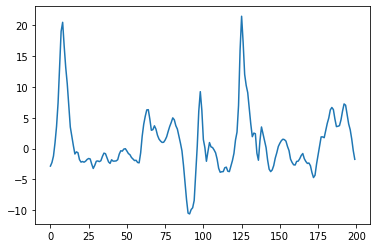

In [295]:
x = np.arange(len(a))
import matplotlib.pyplot as plt
plt.plot(x,a)
plt.show()

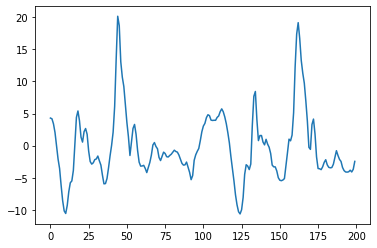

In [296]:
plt.plot(x,b)
plt.show()

In [285]:
def takeBatch(batchsize, trainSet, h, w):
    num_sample = len(trainSet)
    random.shuffle(trainSet)
    for i in range(0,num_sample-batchsize+1, batchsize):
        x1s = np.zeros((batchsize, h, w))
        x2s = np.zeros((batchsize, h, w))
        ys = np.zeros((batchsize,1))
        for j in range(batchsize):
            x1s[j, :, :] = trainSet[i+j].x1
            x2s[j, :, :] = trainSet[i+j].x2
            ys[j] = trainSet[i+j].label
            
        x1s = torch.from_numpy(x1s).float()
        x2s = torch.from_numpy(x2s).float()
        x1s = x1s.view(batchsize, 1, h, w)
        x2s = x2s.view(batchsize, 1, h, w)
        yield x1s, x2s, ys
        
# count = 0
# for x1s, x2s, ys in takeBacth(40, trainDict):
#     print(len(ys[ys == 1]))
#     print(len(ys[ys == 0]))
#     count += 1
# print(count)

In [286]:
def validatation(valSet, h, w):
    num_sample = len(valSet)
    x1s = np.zeros((num_sample, h, w))
    x2s = np.zeros((num_sample, h, w))
    ys = np.zeros((num_sample,1))
    for i in range(num_sample):
        x1s[i, :, :] = valSet[i].x1
        x2s[i, :, :] = valSet[i].x2
        ys[i] = valSet[i].label
    x1s = torch.from_numpy(x1s).float()
    x2s = torch.from_numpy(x2s).float()
    x1s = x1s.view(num_sample, 1, h, w)
    x2s = x2s.view(num_sample, 1, h, w)
    return x1s, x2s, ys

def validate(valX1, valX2, valY, net):
    s = net(valX1, valX2)
    s[s>0.5] = 1
    s[s<=0.5] = 0
    y = torch.from_numpy(valY)
    
    res = s==y
    acc = len(res[res==True])/len(res)
    return acc

In [289]:
def trainBatch(net, data_dict, batch_size = 40, epochs = 1000, lr = 0.008):
    num_sample = len(data_dict['same']) + len(data_dict['diff'])
    h, w = data_dict['same'][0].x1.shape
    dataset = data_dict['same'] + data_dict['diff']
    random.shuffle(dataset)
    trainSet = dataset[:-2000]
    valSet = dataset[-2000:]
    valX1, valX2, valY = validatation(valSet, h, w)
    val_acc = 0
    opt = torch.optim.Adam(net.parameters(), lr)
    loss_func = nn.BCELoss() 
    for epoch in range(epochs):
        train_loss = []
        net.train()
        #count = 0
        for x1s, x2s, ys in takeBatch(batch_size,trainSet, h, w):
            targets = torch.from_numpy(ys).view(batch_size, -1)
            #targets = targets.squeeze()
            opt.zero_grad()
            
            out = net(x1s, x2s)
            loss = loss_func(out, targets.float())
            train_loss.append(loss.item())
            loss.backward()
            opt.step()
        acc = validate(valX1, valX2, valY, net)
        if(acc >= val_acc): # store the model performs best on validation set
            best_model = net
            val_acc = acc
        print("Epoch: {}/{}...".format(epoch+1, epochs),
        "Train Loss: {:.4f}...".format(np.mean(train_loss)),
              "Validation acc: {:.4f}...".format(acc))
    final_model = net
    return final_model, best_model

In [ ]:
net = SiameseNetwork()
net.apply(init_weights)
final_model, best_model = trainBatch(net, trainDict)

Epoch: 1/1000... Train Loss: 0.7079... Validation acc: 0.5160...
Epoch: 2/1000... Train Loss: 0.6939... Validation acc: 0.4850...
Epoch: 3/1000... Train Loss: 0.6935... Validation acc: 0.5150...
Epoch: 4/1000... Train Loss: 0.6934... Validation acc: 0.5145...
Epoch: 5/1000... Train Loss: 0.6934... Validation acc: 0.4850...
Epoch: 6/1000... Train Loss: 0.6933... Validation acc: 0.4850...
Epoch: 7/1000... Train Loss: 0.6951... Validation acc: 0.4900...
Epoch: 8/1000... Train Loss: 0.6936... Validation acc: 0.4850...
Epoch: 9/1000... Train Loss: 0.6934... Validation acc: 0.5150...
Epoch: 10/1000... Train Loss: 0.6933... Validation acc: 0.5155...
Epoch: 11/1000... Train Loss: 0.6935... Validation acc: 0.4855...
Epoch: 12/1000... Train Loss: 0.6935... Validation acc: 0.5150...
Epoch: 13/1000... Train Loss: 0.6933... Validation acc: 0.4850...
Epoch: 14/1000... Train Loss: 0.6932... Validation acc: 0.4850...
Epoch: 15/1000... Train Loss: 0.6932... Validation acc: 0.5150...
Epoch: 16/1000... T